# Import Packages

In [1]:
import os
import pickle

# To see the progress
from tqdm.notebook import tqdm

import numpy as np

# For visualization
import matplotlib.pyplot as plt

# Things related to the pytorch
import torch                                        # main pytorch package
import torch.nn as nn                               # pytorch module for neural network
from torch.utils.data import Dataset, DataLoader    # pytorch utils for dataset

# Make the dataset! add noise to the linear function
- gt_w, gt_b : ground truth weight and bias for linear regression
- x : random points
- y : gt_w * x + gt_b + (gaussian) noise

In [8]:
### make the linear dataset. Define the gt_w and gt_b as you want
gt_w = 4.0
gt_b = -2.0
# y = gt_w * x + gt_b + noise

### define the number of data, and value of noise to add to wx+b.
num_data = 1000
noise_value = 2

### Sample some random X between range -1~1 / or range you want..
x_range = np.array([-1, 1])
x = np.linspace(x_range[0], x_range[1], num_data)
print('shape of x:', x.shape)

### Define some noise to add to wx+b
noise = np.random.randn(num_data) * noise_value
y = gt_w * x + gt_b + noise
print('shape of y:', y.shape)

shape of x: (1000,)
shape of y: (1000,)


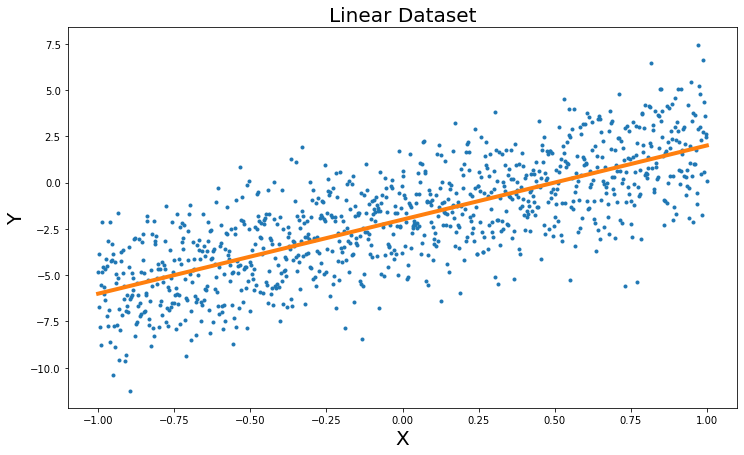

In [9]:
### Plot the dataset
plt.figure(figsize=(12, 7))
plt.plot(x, y, '.')

### Plot the ground truth linear regressor
# x_range = np.array([-1, 1]), gt_w = 4.0, gt_b = -2.0
plt.plot(x_range, x_range * gt_w + gt_b, linewidth=4) # 4x - 2

### Title and extras
plt.title('Linear Dataset', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.show()

# Define the Pytorch Dataset with x y points
- Define your own class, which inherits from "Dataset" class of pytorch
- Define constructor of the class with init
- Define the length of the dataset with len
- Define the function when bringing out the idx-th dataset
    * Return the dictionary containing the input and output of single datapoint


In [11]:
class XY_Dataset(Dataset):
    def __init__(self, x, y):
        '''
        x : input points
        y : output points
        '''
        self.x = x
        self.y = y
        self.num_data = len(self.x)
        print('number of data: {}'.format(self.x.shape))

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        curr_x = self.x[idx]
        curr_y = self.y[idx]

        # dictation that includes data information
        sample = dict()
        sample['x'] = curr_x
        sample['y'] = curr_y

        return sample

# my_data = XY_Dataset(x=x, y=y)
# my_data[0] # index 부여 시 __getitem__ 자동 호출 -> 실제 학습 시에는 index가 아니라 batch 단위로 접근함

# Define the dataset, and dataloader
- DataLoader makes you to randomly sample the dataset with a batch size you want.

In [14]:
### Define the batch size you want
batch_size = 64

### Create the instance of dataset, and dataloader
dataset = XY_Dataset(x, y)
dataloader = DataLoader(dataset, batch_size, shuffle=True)

### Try sampling out one random data point.
sample = next(iter(dataloader))
print(sample.keys())
print(sample['x'].shape) # batch_size
print(sample['y'].shape) # batch_size
print(sample['x'])

number of data: (1000,)
dict_keys(['x', 'y'])
torch.Size([64])
torch.Size([64])
tensor([ 0.1411,  0.4094,  0.8378,  0.7798,  0.6036,  0.3634,  0.3313,  0.4014,
         0.9419, -0.0751, -0.7237, -0.9700, -0.6336, -0.6316,  0.4054, -0.8298,
        -0.8258, -0.7678, -0.3994,  0.8418,  0.3493, -0.1391, -0.1672,  1.0000,
         0.0210,  0.8118, -0.3874, -0.2192,  0.5996, -0.1291, -0.1632,  0.8759,
         0.3614, -0.5455, -0.3493,  0.9179, -0.7337,  0.1391,  0.1812,  0.6977,
        -0.9439, -0.7177,  0.5716, -0.3113, -0.4294,  0.5055, -0.3413, -0.3273,
        -0.3473,  0.2052,  0.8959, -0.1271, -0.3634, -0.3674,  0.7097, -0.2633,
        -0.5335, -0.4895, -0.8599,  0.1672,  0.8599,  0.9680, -0.6677,  0.1091],
       dtype=torch.float64)


# Initialize the weight and bias.

In [26]:
### Needs requires_grad=True, if you want to make as a parameter to train.
pred_w = nn.Parameter(torch.rand(1), requires_grad=True) # requires_grad : trainable or not
pred_b = nn.Parameter(torch.rand(1), requires_grad=True)
print('Initialized w: {}, b: {}'.format(pred_w.item(), pred_b.item())) # nn.Parameter.item() : show elements of the parameter

Initialized w: 0.549507200717926, b: 0.5433734655380249


# Define the ,,train'' function. 

In [16]:
def train(pred_w, pred_b, sample, learning_rate):
    '''
    pred_w : weight to train.
    pred_b : bias to train.
    sample : sample from dataloader. dictionary containing 'x' and 'y'.
    learning_rate : the learning rate you want. 
    pred_loss : predicted loss from this iteration
    '''
    
    # get prediction
    curr_x = sample['x']
    curr_y = sample['y']
    batch_size = curr_x.shape[0]

    pred_y = pred_w * curr_x + pred_b
    
    # calculate the pred_loss
    criteria = nn.MSELoss()
    pred_loss = criteria(pred_y, curr_y) # (prediction, Ground Truth)
    # pred_loss = torch.sqrt(torch.mean((pred_y - curr_y) ** 2))
    
    # make pytorch compute the gradient
    pred_loss.backward()

    # need ``no_grad'' to keep the computed gradient. otherwise, it will generate NoneType
    with torch.no_grad():
        pred_w -= learning_rate * pred_w.grad
        pred_b -= learning_rate * pred_b.grad
        
    # initizlize the gradient to zero
    pred_w.grad.zero_()
    pred_b.grad.zero_()
    
    return pred_loss.item()

# Iterate over the dataset! With your ,,train'' function

In [27]:
# define the maximum epoch
max_epoch = 1000

# define a list to save the loss
loss_saver = list()

# define how often you will print the result
print_stride = 50

# iterate over the dataset for (max_epoch) times
for epoch in tqdm(range(max_epoch)): # tqdm shows progress bar
    total_loss = 0.0
    for idx, sample in enumerate(dataloader):
        curr_loss = train(pred_w, pred_b, sample, learning_rate=0.0005)
        total_loss += curr_loss / len(dataloader) # len(dataloader) : num of batches
    
    loss_saver.append(total_loss)
    
    if (epoch + 1) % print_stride == 0:
        print('[EPOCH {}] LOSS : {}'.format(epoch+1, total_loss)) # weight and bias package 비추
    
print()
print('Final Prediction : pred_w = {}, pred_b = {}'.format(pred_w.item(), pred_b.item()))

  0%|          | 0/1000 [00:00<?, ?it/s]

[EPOCH 50] LOSS : 7.70485239994556
[EPOCH 100] LOSS : 5.669601349978987
[EPOCH 150] LOSS : 4.8678979805743765
[EPOCH 200] LOSS : 4.480599339446762
[EPOCH 250] LOSS : 4.27574091584331
[EPOCH 300] LOSS : 4.147120232671366
[EPOCH 350] LOSS : 4.057631422161489
[EPOCH 400] LOSS : 4.009261918881675
[EPOCH 450] LOSS : 4.006970785697037
[EPOCH 500] LOSS : 3.9941594733380903
[EPOCH 550] LOSS : 3.9887369130059094
[EPOCH 600] LOSS : 3.9894258572433197
[EPOCH 650] LOSS : 3.977146406088835
[EPOCH 700] LOSS : 3.972094532787753
[EPOCH 750] LOSS : 3.9876075033189022
[EPOCH 800] LOSS : 3.980245974105016
[EPOCH 850] LOSS : 3.9576013728270847
[EPOCH 900] LOSS : 3.958807559446721
[EPOCH 950] LOSS : 3.966838943684772
[EPOCH 1000] LOSS : 3.961708645058038

Final Prediction : pred_w = 4.037976264953613, pred_b = -1.9979517459869385


# Plot the result : training loss and resulted linear regressor

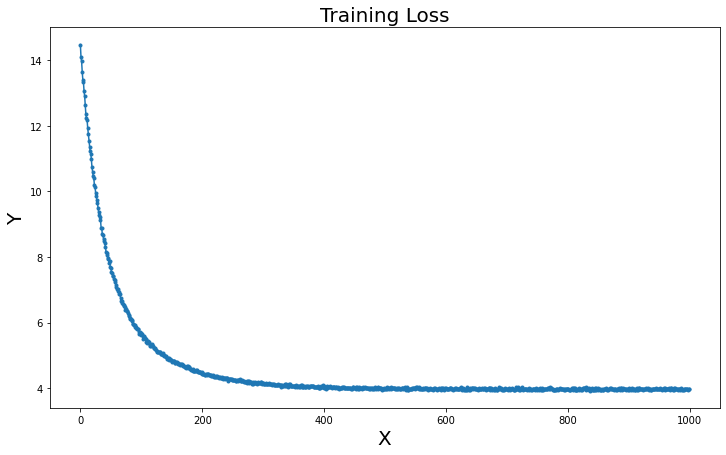

In [28]:
loss_saver = np.array(loss_saver)
plt.figure(figsize=(12, 7))
plt.plot(np.arange(len(loss_saver)), loss_saver, '.-')
plt.title('Training Loss', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.show()

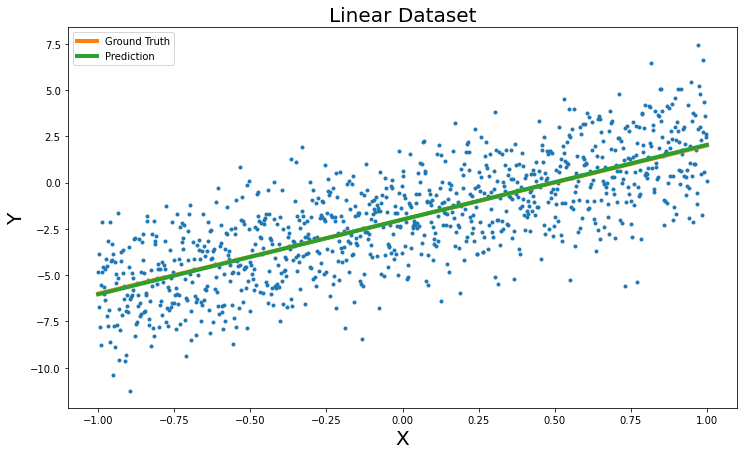

In [29]:
plt.figure(figsize=(12, 7))

### Plot the dataset
plt.plot(x, y, '.')

### Plot the ground truth + predicted linear regressor
plt.plot(x_range, x_range * gt_w + gt_b, linewidth=4, label='Ground Truth')
plt.plot(x_range, x_range * pred_w.item() + pred_b.item(), linewidth=4, label='Prediction')

### Title and extras
plt.title('Linear Dataset', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.legend()
plt.show()